<a href="https://colab.research.google.com/github/raif-rizvi/Amazon_Product_Recommendation_System/blob/main/Recommendation_Systems_rrizvi.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [57]:
!git clone https://github.com/raif-rizvi/Amazon_Product_Recommendation_System.git


fatal: destination path 'Amazon_Product_Recommendation_System' already exists and is not an empty directory.


# **Amazon Product Recommendation System**



Welcome to the project on Recommendation Systems. We will work with the Amazon product reviews dataset for this project. The dataset contains ratings of different electronic products. It does not include information about the products or reviews to avoid bias while building the model.

--------------
## **Context:**
--------------

Today, information is growing exponentially with volume, velocity and variety throughout the globe. This has lead to information overload, and too many choices for the consumer of any business. It represents a real dilemma for these consumers and they often turn to denial. Recommender Systems are one of the best tools that help recommending products to consumers while they are browsing online. Providing personalized recommendations which is most relevant for the user is what's most likely to keep them engaged and help business.

E-commerce websites like Amazon, Walmart, Target and Etsy use different recommendation models to provide personalized suggestions to different users. These companies spend millions of dollars to come up with algorithmic techniques that can provide personalized recommendations to their users.

Amazon, for example, is well-known for its accurate selection of recommendations in its online site. Amazon's recommendation system is capable of intelligently analyzing and predicting customers' shopping preferences in order to offer them a list of recommended products. Amazon's recommendation algorithm is therefore a key element in using AI to improve the personalization of its website. For example, one of the baseline recommendation models that Amazon uses is item-to-item collaborative filtering, which scales to massive data sets and produces high-quality recommendations in real-time.

----------------
## **Objective:**
----------------

You are a Data Science Manager at Amazon, and have been given the task of building a recommendation system to recommend products to customers based on their previous ratings for other products. You have a collection of labeled data of Amazon reviews of products. The goal is to extract meaningful insights from the data and build a recommendation system that helps in recommending products to online consumers.

-----------------------------
## **Dataset:**
-----------------------------

The Amazon dataset contains the following attributes:

- **userId:** Every user identified with a unique id
- **productId:** Every product identified with a unique id
- **Rating:** The rating of the corresponding product by the corresponding user
- **timestamp:** Time of the rating. We **will not use this column** to solve the current problem

Sometimes, the installation of the surprise library, which is used to build recommendation systems, faces issues in Jupyter. To avoid any issues, it is advised to use **Google Colab** for this project.

Let's start by mounting the Google drive on Colab.

In [58]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**Installing surprise library**

In [59]:
!pip install surprise

## **Importing the necessary libraries and overview of the dataset**

In [60]:
# Numerical and DataFrame python libraries
import numpy as np
import pandas as pd

# Python libraries for visualization
import matplotlib.pyplot as plt
import seaborn as sns

# For implementing matrix factorization based recommendation system
from surprise.prediction_algorithms.matrix_factorization import SVD
from collections import defaultdict

# For implementing cross validation
from surprise.model_selection import KFold

# Importing sklearn.metrics for model evaluation.
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, mean_squared_error, mean_absolute_error, r2_score
)

import warnings
warnings.filterwarnings('ignore')

### **Loading the data**
- Import the Dataset
- Add column names ['user_id', 'prod_id', 'rating', 'timestamp']
- Drop the column timestamp
- Copy the data to another DataFrame called **df**

**Import the Dataset**

In [61]:
df=pd.read_csv('/content/Amazon_Product_Recommendation_System/ratings_Electronics.csv')

In [62]:
#first few lines of the dataset to check before adding the column names
df.head(10)


,AKM1MP6P0OYPR,0132793040,5.0,1365811200
0,A2CX7LUOHB2NDG,0321732944,5.0,1341100800
1,A2NWSAGRHCP8N5,0439886341,1.0,1367193600
2,A2WNBOD3WNDNKT,0439886341,3.0,1374451200
3,A1GI0U4ZRJA8WN,0439886341,1.0,1334707200
4,A1QGNMC6O1VW39,0511189877,5.0,1397433600
5,A3J3BRHTDRFJ2G,0511189877,2.0,1397433600
6,A2TY0BTJOTENPG,0511189877,5.0,1395878400
7,A34ATBPOK6HCHY,0511189877,5.0,1395532800
8,A89DO69P0XZ27,0511189877,5.0,1395446400
9,AZYNQZ94U6VDB,0511189877,5.0,1401321600


**Add column names ['user_id', 'prod_id', 'rating', 'timestamp']**

In [63]:
#Looks like there are no headers , lets add in them in
df.columns = ['user_id', 'prod_id', 'rating', 'timestamp']

**Drop the column timestamp**

In [64]:
#Drop Timestamp as it is not required for this analysis
df=df.drop('timestamp',axis= 1)

**Copy the data to another DataFrame called df_copy**

In [65]:
# Create a copy for referencing , if required
df_copy = df.copy

In [66]:
#lets get a sense of the dataset
df.info()

# Columns to count unique occurrences
columns_to_count = ['user_id', 'prod_id', 'rating']

# Count unique occurrences for each column
for column in columns_to_count:
    unique_counts = df[column].value_counts()
    print(f"Unique counts for {column}:")
    print(unique_counts)
    print()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7824481 entries, 0 to 7824480
Data columns (total 3 columns):
 #   Column   Dtype  
---  ------   -----  
 0   user_id  object 
 1   prod_id  object 
 2   rating   float64
dtypes: float64(1), object(2)
memory usage: 179.1+ MB
Unique counts for user_id:
A5JLAU2ARJ0BO     520
ADLVFFE4VBT8      501
A3OXHLG6DIBRW8    498
A6FIAB28IS79      431
A680RUE1FDO8B     406
                 ... 
A1WBP7XSZI6AUL      1
A2K7UNJHE9ZR0G      1
A1A6SIW6EWF6FP      1
A1JRDVWYUF8W0P      1
A10M2KEFPEQDHN      1
Name: user_id, Length: 4201696, dtype: int64

Unique counts for prod_id:
B0074BW614    18244
B00DR0PDNE    16454
B007WTAJTO    14172
B0019EHU8G    12285
B006GWO5WK    12226
              ...  
B004WL91KI        1
B004WL9FK4        1
B004WL9Q2Q        1
B004WL9R8O        1
BT008V9J9U        1
Name: prod_id, Length: 476001, dtype: int64

Unique counts for rating:
5.0    4347540
4.0    1485781
1.0     901765
3.0     633073
2.0     456322
Name: rating, dt

--------------
**Observations**
--------------
--------------
- The dataset has a total of 7,824,481 entries.
- The dataset has three columns: 'user_id', 'prod_id', and 'rating'.
- All three columns have non-null values for all 7,824,481 entries.
- The 'user_id' column has 4,201,696 unique values, with 'A5JLAU2ARJ0BO' appearing the most frequently (520 occurrences).
- The 'prod_id' column has 476,001 unique values, with 'B0074BW614' appearing the most frequently (18,244 occurrences).
- The 'rating' column has five unique values (5.0, 4.0, 1.0, 3.0, and 2.0). The most frequent rating is 5.0, which appears 4,347,540 times.

Now, let's discuss the sparse nature of ratings in recommendation systems.

In recommendation systems, it is common to encounter sparse data, where most users have not rated most items. This sparsity arises due to the vast number of available items and the limited number of ratings provided by users. In the provided dataset, there are 7,824,481 entries, but there are 4,201,696 unique users and 476,001 unique products (2,000,011,497,696 possible combinations).
3.91 * 10^-4 % completion


**As this dataset is very large and has 7,824,481 observations, it is not computationally possible to build a model using this. Moreover, many users have only rated a few products and also some products are rated by very few users. Hence, we can reduce the dataset by considering certain logical assumptions.**

Here, we will be taking users who have given at least 50 ratings, and the products that have at least 5 ratings, as when we shop online we prefer to have some number of ratings of a product.

In [67]:
# Get the column containing the users
users = df.user_id

# Create a dictionary from users to their number of ratings
ratings_count = dict()

for user in users:

    # If we already have the user, just add 1 to their rating count
    if user in ratings_count:
        ratings_count[user] += 1

    # Otherwise, set their rating count to 1
    else:
        ratings_count[user] = 1

In [68]:
# We want our users to have at least 50 ratings to be considered
RATINGS_CUTOFF = 50

remove_users = []

for user, num_ratings in ratings_count.items():
    if num_ratings < RATINGS_CUTOFF:
        remove_users.append(user)

df = df.loc[ ~ df.user_id.isin(remove_users)]

In [69]:
# Get the column containing the products
prods = df.prod_id

# Create a dictionary from products to their number of ratings
ratings_count = dict()

for prod in prods:

    # If we already have the product, just add 1 to its rating count
    if prod in ratings_count:
        ratings_count[prod] += 1

    # Otherwise, set their rating count to 1
    else:
        ratings_count[prod] = 1

In [70]:
# We want our item to have at least 5 ratings to be considered
RATINGS_CUTOFF = 5

remove_users = []

for user, num_ratings in ratings_count.items():
    if num_ratings < RATINGS_CUTOFF:
        remove_users.append(user)

df_final = df.loc[~ df.prod_id.isin(remove_users)]

In [71]:
# Print a few rows of the imported dataset
df_final.head()

,user_id,prod_id,rating
1309,A3LDPF5FMB782Z,1400501466,5.0
1321,A1A5KUIIIHFF4U,1400501466,1.0
1334,A2XIOXRRYX0KZY,1400501466,3.0
1450,AW3LX47IHPFRL,1400501466,5.0
1455,A1E3OB6QMBKRYZ,1400501466,1.0


## **Exploratory Data Analysis**

### **Shape of the data**

### **Check the number of rows and columns and provide observations.**

In [72]:
# Check the number of rows and columns and provide observations
#Unpacking df_final.shape to appropriate labels
rows, columns = df_final.shape
print(f"The DataFrame has {rows} rows and {columns} columns.")

The DataFrame has 65290 rows and 3 columns.


**The DataFrame has 65290 rows and 3 columns.**

### **Data types**

In [73]:
# Check Data types and provide observations
#lets get a sense of the final dataset
df_final.info()

# Columns to count unique occurrences
columns_to_count = ['user_id', 'prod_id', 'rating']

#Count and normalised count
for column in columns_to_count:
    unique_counts = df_final[column].value_counts()
    total_rows = df_final.shape[0]
    normalized_count = unique_counts / total_rows

    print(f"Unique counts for {column}:")
    print(unique_counts)
    print(f"Normalized count for {column}:")
    print(normalized_count)
    print()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 65290 entries, 1309 to 7824426
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   user_id  65290 non-null  object 
 1   prod_id  65290 non-null  object 
 2   rating   65290 non-null  float64
dtypes: float64(1), object(2)
memory usage: 2.0+ MB
Unique counts for user_id:
ADLVFFE4VBT8      295
A3OXHLG6DIBRW8    230
A1ODOGXEYECQQ8    217
A36K2N527TXXJN    212
A25C2M3QF9G7OQ    203
                 ... 
A16CVJUQOB6GIB      2
A2BGZ52M908MJY      2
A3DL29NLZ7SXXG      1
AP2NZAALUQKF5       1
A3MV1KKHX51FYT      1
Name: user_id, Length: 1540, dtype: int64
Normalized count for user_id:
ADLVFFE4VBT8      0.004518
A3OXHLG6DIBRW8    0.003523
A1ODOGXEYECQQ8    0.003324
A36K2N527TXXJN    0.003247
A25C2M3QF9G7OQ    0.003109
                    ...   
A16CVJUQOB6GIB    0.000031
A2BGZ52M908MJY    0.000031
A3DL29NLZ7SXXG    0.000015
AP2NZAALUQKF5     0.000015
A3MV1KKHX51FYT    0.000015
Name: u

--------------
**Observations**
--------------
--------------
- The df_final reduced dataset has a total of 65,290 entries.
- The dataset has three columns: 'user_id', 'prod_id', and 'rating'.
- All three columns have non-null values for all 65,290 entries.
- The 'user_id' column has 1,540 unique values, with 'ADLVFFE4VBT8' appearing the most frequently (295 occurrences).
- The normalized count (frequency) for the 'user_id' column shows that 'ADLVFFE4VBT8' accounts for approximately 0.45% of the total entries.
- The 'prod_id' column has 5,689 unique values, with 'B0088CJT4U' appearing the most frequently (206 occurrences).
- The normalized count (frequency) for the 'prod_id' column shows that 'B0088CJT4U' accounts for approximately 0.32% of the total entries.
- The 'rating' column has five unique values (5.0, 4.0, 3.0, 2.0, and 1.0). The most frequent rating is 5.0, which appears 36,315 times.
- The normalized count (frequency) for the 'rating' column shows that 55.6% of the ratings are 5.0, followed by 27.8% for 4.0, 9.9% for 3.0, 3.9% for 2.0, and 2.8% for 1.0. Seems like most data is skewed in favour of higher ratings. We can confirm this fact in further EDA.

### **Checking for missing values**

In [74]:
# Check for missing values present and provide observations
df_final.isnull().sum()

user_id    0
prod_id    0
rating     0
dtype: int64

**No Missing Value**

### **Summary Statistics**

In [75]:
# Summary statistics of 'rating' variable and provide observations
df_final['rating'].describe().T

count    65290.000000
mean         4.294808
std          0.988915
min          1.000000
25%          4.000000
50%          5.000000
75%          5.000000
max          5.000000
Name: rating, dtype: float64

**Observation**

- The average rating given by users for products is approximately 4.29, indicating that users generally provide positive / higher ratings. We must also be aware that the ratings are actually classes, but do also hold ordinal information.
- The standard deviation of the ratings is around 0.99, suggesting a moderate amount of variability in the ratings.
- The minimum rating given by a user is 1, indicating that some users have given low ratings to certain products.
- The 25th percentile rating is 4, indicating that only 25% of the ratings fall below or equal to 4.
- The median rating (50th percentile) is 5, suggesting that half of the ratings are 5 or below.
- The 75th percentile rating is 5, indicating that 75% of the ratings fall below or equal to 5.
- The maximum rating given by a user is 5, implying that some users have given the highest rating to certain products.

Overall, the ratings in the `df_final` DataFrame show a positive skew, with a majority of ratings being high (4 or 5). However, there is some variability in the ratings, with a small portion of users providing lower ratings as well. Lets the visualize these observations


### **Checking the rating distribution**

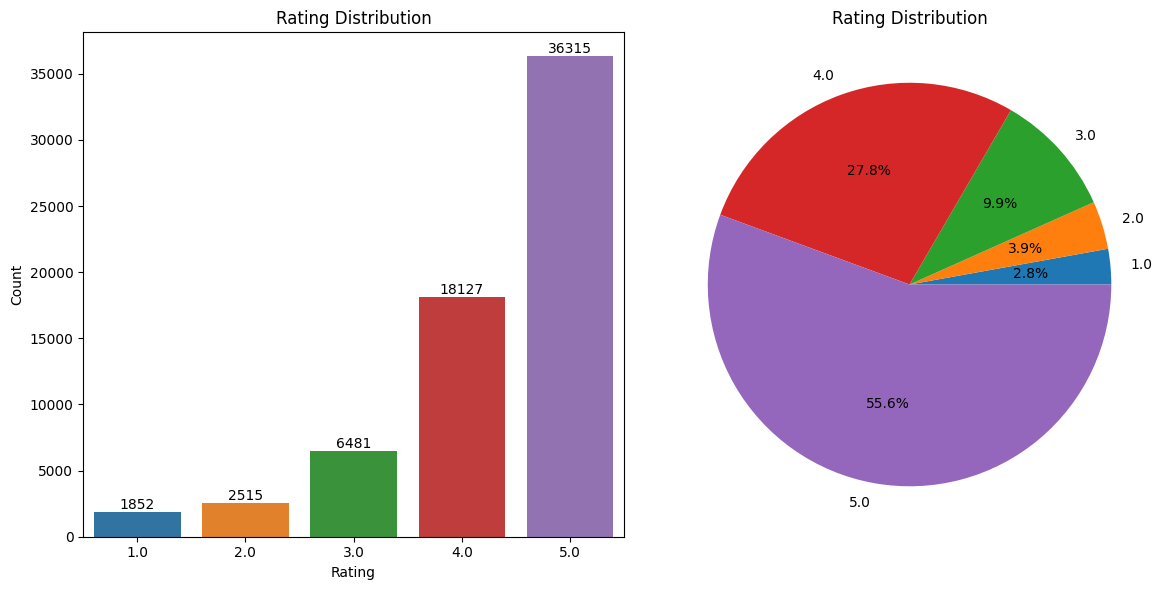

In [76]:
import seaborn as sns
import matplotlib.pyplot as plt

# Count the frequency of each rating
rating_counts = df_final['rating'].value_counts().sort_index()

# Create the figure and axes for subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Plot the bar plot in the first subplot using seaborn
sns.barplot(x=rating_counts.index, y=rating_counts.values, ax=axes[0])
axes[0].set_title('Rating Distribution')
axes[0].set_xlabel('Rating')
axes[0].set_ylabel('Count')

# Add data labels to the bar plot
for i, count in enumerate(rating_counts.values):
    axes[0].text(i, count, str(count), ha='center', va='bottom')

# Plot the pie chart in the second subplot
rating_labels = rating_counts.index.astype(str)
axes[1].pie(rating_counts.values, labels=rating_labels, autopct='%1.1f%%')
axes[1].set_title('Rating Distribution')

# Adjust the spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()



---------------
**Observation**
---------------
---------------
- As mentioned before. The 'rating' column has five unique values (5.0, 4.0, 3.0, 2.0, and 1.0). The most frequent rating is 5.0, which appears 36,315 times.
- The normalized count (frequency) for the 'rating' column shows that 55.6% of the ratings are 5.0, followed by 27.8% for 4.0, 9.9% for 3.0, 3.9% for 2.0, and 2.8% for 1.0. we have confirmed data is skewed in favour of higher ratings

### **Checking the number of unique users and items in the dataset**

In [77]:
# Number of total rows in the data and number of unique user id and product id in the data

# Number of total rows in the data
total_rows = df_final.shape[0]
print("Number of total rows in the data:", total_rows)

# Number of unique user IDs in the data
unique_user_ids = df_final['user_id'].nunique()
print("Number of unique user IDs in the data:", unique_user_ids)

# Number of unique product IDs in the data
unique_product_ids = df_final['prod_id'].nunique()
print("Number of unique product IDs in the data:", unique_product_ids)


Number of total rows in the data: 65290
Number of unique user IDs in the data: 1540
Number of unique product IDs in the data: 5689


**Observations**

- Number of total rows in the data: 65290

- Number of unique user IDs in the data: 1540

- Number of unique product IDs in the data: 5689

### **Users with the most number of ratings**

In [78]:
# Top 10 users based on the number of ratings
# Get the count of ratings for each user
user_rating_counts = df_final['user_id'].value_counts()

# Get the top 10 users based on ratings
top_10_users = user_rating_counts.head(10)

# Print the top 10 users
print("Top 10 users based on the number of ratings:")
print(top_10_users)


# Calculate the total number of ratings
total_ratings = df_final.shape[0]

# Calculate the number of ratings by the top 10 users
top_10_ratings = top_10_users.sum()

# Calculate the percentage of total ratings captured by the top 10 users
percentage = (top_10_ratings / total_ratings) * 100

# Print the percentage
print("Percentage of total ratings captured by the top 10 users: {:.2f}%".format(percentage))


Top 10 users based on the number of ratings:
ADLVFFE4VBT8      295
A3OXHLG6DIBRW8    230
A1ODOGXEYECQQ8    217
A36K2N527TXXJN    212
A25C2M3QF9G7OQ    203
A680RUE1FDO8B     196
A1UQBFCERIP7VJ    193
A22CW0ZHY3NJH8    193
AWPODHOB4GFWL     184
AGVWTYW0ULXHT     179
Name: user_id, dtype: int64
Percentage of total ratings captured by the top 10 users: 3.22%


--------------------
**Observations**
--------------------
--------------------
Top 10 users based on the number of ratings:

|     User ID     | Count |
|:--------------:|:------:|
| ADLVFFE4VBT8 | 295 |
| A3OXHLG6DIBRW8 | 230 |
| A1ODOGXEYECQQ8 | 217 |
| A36K2N527TXXJN | 212 |
| A25C2M3QF9G7OQ | 203 |
| A680RUE1FDO8B | 196 |
| A1UQBFCERIP7VJ | 193 |
| A22CW0ZHY3NJH8 | 193 |
| AWPODHOB4GFWL | 184 |
| AGVWTYW0ULXHT | 179 |



**Percentage of total ratings captured by the top 10 users: 3.22%**

**Highest Ratings Count : 295**

**Number of unique product IDs in the data: 5689**

**Even the Highest 'rater' has only rated 5.18% of products and hence even the highest rater needs rating for aroung 95% of the products**

**Now that we have explored and prepared the data, let's build the first recommendation system.**

## **Model 1: Rank Based Recommendation System**

In [79]:
# Calculate the average rating for each product
product_avg_rating = df_final.groupby('prod_id')['rating'].mean()

# Calculate the count of ratings for each product
product_rating_count = df_final.groupby('prod_id')['rating'].count()


# Create a dataframe with calculated average and count of ratings
final_rating = pd.DataFrame({'Average Rating': product_avg_rating, 'Rating Count': product_rating_count})


# Sort the dataframe by average of ratings in the descending order
final_rating = final_rating.sort_values('Average Rating', ascending=False)

# See the first five records of the "final_rating" dataset
final_rating.head()

,Average Rating,Rating Count
prod_id,,
B00LGQ6HL8,5.0,5
B003DZJQQI,5.0,14
B005FDXF2C,5.0,7
B00I6CVPVC,5.0,7
B00B9KOCYA,5.0,8


In [80]:
# Defining a function to get the top n products based on the highest average rating and minimum interactions
def top_products(df, n, min_interactions):

  # Finding products with minimum number of interactions
  filtered= df[df['Rating Count']>=min_interactions]

  # Sorting values with respect to average rating
  sorted = filtered.sort_values('Average Rating', ascending= False)

  #Top N Items
  top_n_products = sorted.head(n)
  return top_n_products



### **Recommending top 5 products with 50 minimum interactions based on popularity**

In [81]:
# df = final_rating
# n = 5
# min_interactions = 50

top_products_50 = top_products(final_rating,5,50)

print("Top 5 products based on highest average rating and minimum interactions of 50:" , top_products_50)

Top 5 products based on highest average rating and minimum interactions of 50:             Average Rating  Rating Count
prod_id                                 
B001TH7GUU        4.871795            78
B003ES5ZUU        4.864130           184
B0019EHU8G        4.855556            90
B006W8U2MU        4.824561            57
B000QUUFRW        4.809524            84


### **Recommending top 5 products with 100 minimum interactions based on popularity**

In [82]:
# df = final_rating
# n = 5
# min_interactions = 100

top_products_50 = top_products(final_rating,5,100)

print("Top 5 products based on highest average rating and minimum interactions of 100:" , top_products_50)

Top 5 products based on highest average rating and minimum interactions of 100:             Average Rating  Rating Count
prod_id                                 
B003ES5ZUU        4.864130           184
B000N99BBC        4.772455           167
B002WE6D44        4.770000           100
B007WTAJTO        4.701220           164
B002V88HFE        4.698113           106


We have recommended the **top 5** products by using the popularity recommendation system. Now, let's build a recommendation system using **collaborative filtering.**

## **Model 2: Collaborative Filtering Recommendation System**

### **Building a baseline user-user similarity based recommendation system**

- Below, we are building **similarity-based recommendation systems** using `cosine` similarity and using **KNN to find similar users** which are the nearest neighbor to the given user.  
- We will be using a new library, called `surprise`, to build the remaining models. Let's first import the necessary classes and functions from this library.

In [83]:
# To compute the accuracy of models
from surprise import accuracy

# Class is used to parse a file containing ratings, data should be in structure - user ; item ; rating
from surprise.reader import Reader

# Class for loading datasets
from surprise.dataset import Dataset

# For tuning model hyperparameters
from surprise.model_selection import GridSearchCV

# For splitting the rating data in train and test datasets
from surprise.model_selection import train_test_split

# For implementing similarity-based recommendation system
from surprise.prediction_algorithms.knns import KNNBasic

# For implementing matrix factorization based recommendation system
from surprise.prediction_algorithms.matrix_factorization import SVD

# for implementing K-Fold cross-validation
from surprise.model_selection import KFold

# For implementing clustering-based recommendation system
from surprise import CoClustering

**Before building the recommendation systems, let's  go over some basic terminologies we are going to use:**

**Relevant item:** An item (product in this case) that is actually **rated higher than the threshold rating** is relevant, if the **actual rating is below the threshold then it is a non-relevant item**.  

**Recommended item:** An item that's **predicted rating is higher than the threshold is a recommended item**, if the **predicted rating is below the threshold then that product will not be recommended to the user**.  


**False Negative (FN):** It is the **frequency of relevant items that are not recommended to the user**. If the relevant items are not recommended to the user, then the user might not buy the product/item. This would result in the **loss of opportunity for the service provider**, which they would like to minimize.

**False Positive (FP):** It is the **frequency of recommended items that are actually not relevant**. In this case, the recommendation system is not doing a good job of finding and recommending the relevant items to the user. This would result in **loss of resources for the service provider**, which they would also like to minimize.

**Recall:** It is the **fraction of actually relevant items that are recommended to the user**, i.e., if out of 10 relevant products, 6 are recommended to the user then recall is 0.60. Higher the value of recall better is the model. It is one of the metrics to do the performance assessment of classification models.

**Precision:** It is the **fraction of recommended items that are relevant actually**, i.e., if out of 10 recommended items, 6 are found relevant by the user then precision is 0.60. The higher the value of precision better is the model. It is one of the metrics to do the performance assessment of classification models.

**While making a recommendation system, it becomes customary to look at the performance of the model. In terms of how many recommendations are relevant and vice-versa, below are some most used performance metrics used in the assessment of recommendation systems.**

### **Precision@k, Recall@ k, and F1-score@k**

**Precision@k** - It is the **fraction of recommended items that are relevant in `top k` predictions**. The value of k is the number of recommendations to be provided to the user. One can choose a variable number of recommendations to be given to a unique user.  


**Recall@k** - It is the **fraction of relevant items that are recommended to the user in `top k` predictions**.

**F1-score@k** - It is the **harmonic mean of Precision@k and Recall@k**. When **precision@k and recall@k both seem to be important** then it is useful to use this metric because it is representative of both of them.

### **Some useful functions**

- Below function takes the **recommendation model** as input and gives the **precision@k, recall@k, and F1-score@k** for that model.  
- To compute **precision and recall**, **top k** predictions are taken under consideration for each user.
- We will use the precision and recall to compute the F1-score.

In [84]:
def precision_recall_at_k(model, k = 10, threshold = 3.5):
    """Return precision and recall at k metrics for each user"""

    # First map the predictions to each user
    user_est_true = defaultdict(list)

    # Making predictions on the test data
    predictions = model.test(testset)

    for uid, _, true_r, est, _ in predictions:
        user_est_true[uid].append((est, true_r))

    precisions = dict()
    recalls = dict()
    for uid, user_ratings in user_est_true.items():

        # Sort user ratings by estimated value
        user_ratings.sort(key = lambda x: x[0], reverse = True)

        # Number of relevant items
        n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)

        # Number of recommended items in top k
        n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[:k])

        # Number of relevant and recommended items in top k
        n_rel_and_rec_k = sum(((true_r >= threshold) and (est >= threshold))
                              for (est, true_r) in user_ratings[:k])

        # Precision@K: Proportion of recommended items that are relevant
        # When n_rec_k is 0, Precision is undefined. Therefore, we are setting Precision to 0 when n_rec_k is 0

        precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 0

        # Recall@K: Proportion of relevant items that are recommended
        # When n_rel is 0, Recall is undefined. Therefore, we are setting Recall to 0 when n_rel is 0

        recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 0

    # Mean of all the predicted precisions are calculated.
    precision = round((sum(prec for prec in precisions.values()) / len(precisions)), 3)

    # Mean of all the predicted recalls are calculated.
    recall = round((sum(rec for rec in recalls.values()) / len(recalls)), 3)

    accuracy.rmse(predictions)

    print('Precision: ', precision) # Command to print the overall precision

    print('Recall: ', recall) # Command to print the overall recall

    print('F_1 score: ', round((2*precision*recall)/(precision+recall), 3)) # Formula to compute the F-1 score

**Hints:**

- To compute **precision and recall**, a **threshold of 3.5 and k value of 10 can be considered for the recommended and relevant ratings**.
- Think about the performance metric to choose.

Below we are loading the **`rating` dataset**, which is a **pandas DataFrame**, into a **different format called `surprise.dataset.DatasetAutoFolds`**, which is required by this library. To do this, we will be **using the classes `Reader` and `Dataset`.**

In [85]:
# Instantiating Reader scale with expected rating scale
reader = Reader(rating_scale= (0,5))
# Loading the rating dataset
data = Dataset.load_from_df(df_final[['user_id','prod_id','rating']],reader)
# Splitting the data into train and test datasets
trainset, testset = train_test_split(data, test_size= 0.3, random_state= 42)

Now, we are **ready to build the first baseline similarity-based recommendation system** using the cosine similarity.

### **Building the user-user Similarity-based Recommendation System**

In [86]:
# Declaring the similarity options
sim_options = {'name' : 'cosine', 'user_based' : True}

# Initialize the KNNBasic model using sim_options declared, Verbose = False, and setting random_state = 1
knn_user = KNNBasic(sim_options=sim_options , verbose= False)

# Fit the model on the training data
knn_user.fit(trainset)

# Let us compute precision@k, recall@k, and f_1 score using the precision_recall_at_k function defined above
precision_recall_at_k(knn_user)

RMSE: 1.0250
Precision:  0.86
Recall:  0.783
F_1 score:  0.82


**Observations:**

- We can observe that the baseline model has **RMSE=1.025** on the test set.
- Intuition of Recall - We are getting a **recall of ~0.78**, which means out of **all the relevant items, 78% are recommended**.
- Intuition of Precision - We are getting a **precision of ~ 0.86**, which means **out of all the recommended item, 86% are relevant**.
- Here **F_1 score** of the **baseline model is ~0.82**. It indicates that **mostly recommended items were relevant and relevant items were recommended**. We can try to improve the performance by using **GridSearchCV to tune different hyperparameters** of the algorithm.


Let's now **predict rating for a user with `userId=A3LDPF5FMB782Z` and `productId=1400501466`** as shown below. Here the user has already interacted or watched the product with productId '1400501466' and given a rating of 5.

In [87]:
df_final[(df_final['prod_id'] == '1400501466') & (df_final['user_id'] == 'A3LDPF5FMB782Z')]

,user_id,prod_id,rating
1309,A3LDPF5FMB782Z,1400501466,5.0


In [88]:
# Predicting rating for a sample user with an interacted product
knn_user.predict('A3LDPF5FMB782Z','1400501466', r_ui = 5, verbose= True)

user: A3LDPF5FMB782Z item: 1400501466 r_ui = 5.00   est = 3.00   {'actual_k': 4, 'was_impossible': False}


Prediction(uid='A3LDPF5FMB782Z', iid='1400501466', r_ui=5, est=3.0, details={'actual_k': 4, 'was_impossible': False})

- We observe that the actual rating for this user-item pair is 5 and predicted rating is 3 by this similarity based baseline model, which is not that great.

Below is the **list of users who have not seen the product with product id "1400501466"**.

In [89]:
# Find unique user_id where prod_id is not equal to "1400501466"
df_final[(df_final['prod_id'] != '1400501466')].user_id.unique()

array(['A2ZR3YTMEEIIZ4', 'A3CLWR1UUZT6TG', 'A5JLAU2ARJ0BO', ...,
       'A215WH6RUDUCMP', 'A38C12950IM24P', 'A2J4XMWKR8PPD0'], dtype=object)

In [90]:
df_final[(df_final['user_id'] == 'A34BZM6S9L7QI4')]

,user_id,prod_id,rating
1161051,A34BZM6S9L7QI4,B000MDZKUU,5.0
1544020,A34BZM6S9L7QI4,B000ZH98LU,4.0
2821792,A34BZM6S9L7QI4,B002S53LJ2,5.0
2898609,A34BZM6S9L7QI4,B002VPE1Q6,5.0
2914884,A34BZM6S9L7QI4,B002WE6D44,5.0
...,...,...,...
7806777,A34BZM6S9L7QI4,B00J5174TU,5.0
7807175,A34BZM6S9L7QI4,B00J5DS8NE,5.0
7807279,A34BZM6S9L7QI4,B00J5HDEPC,3.0
7823884,A34BZM6S9L7QI4,B00KYMCJF8,5.0


* It can be observed from the above list that **user "A34BZM6S9L7QI4" has not seen the product with productId "1400501466"** as this userId is a part of the above list.

**Below we are predicting rating for `userId=A34BZM6S9L7QI4` and `prod_id=1400501466`.**

In [91]:
# Predicting rating for a sample user with a non interacted product
knn_user.predict('A34BZM6S9L7QI4','1400501466', verbose= True)

user: A34BZM6S9L7QI4 item: 1400501466 r_ui = None   est = 4.29   {'was_impossible': True, 'reason': 'Not enough neighbors.'}


Prediction(uid='A34BZM6S9L7QI4', iid='1400501466', r_ui=None, est=4.291403190162572, details={'was_impossible': True, 'reason': 'Not enough neighbors.'})

** It can be observed from the above list that **user "A34BZM6S9L7QI4" predicted product rating with productId "1400501466"** is estimated 4.29 or rounded off to 4.00

### **Improving similarity-based recommendation system by tuning its hyperparameters**

Below, we will be tuning hyperparameters for the `KNNBasic` algorithm. Let's try to understand some of the hyperparameters of the KNNBasic algorithm:

- **k** (int) – The (max) number of neighbors to take into account for aggregation. Default is 40.
- **min_k** (int) – The minimum number of neighbors to take into account for aggregation. If there are not enough neighbors, the prediction is set to the global mean of all ratings. Default is 1.
- **sim_options** (dict) – A dictionary of options for the similarity measure. And there are four similarity measures available in surprise -
    - cosine
    - msd (default)
    - Pearson
    - Pearson baseline

In [92]:
# Setting up parameter grid to tune the hyperparameters
param_grid = {'k': [20, 30, 40], 'min_k': [3, 5, 9],
              'sim_options': {'name': ['msd', 'cosine'],
                              'user_based': [True]}
              }
# Performing 3-fold cross-validation to tune the hyperparameters
gscv = GridSearchCV(KNNBasic , param_grid,measures= ['rmse','mae'], cv=3 , n_jobs = -1)

# Fitting the data
gscv.fit(data)

# Best RMSE score
gscv.best_score['rmse']

# Combination of parameters that gave the best RMSE score
gscv.best_params['rmse']

{'k': 40, 'min_k': 5, 'sim_options': {'name': 'cosine', 'user_based': True}}

Once the grid search is **complete**, we can get the **optimal values for each of those hyperparameters**.

{'k': 40, 'min_k': 5, 'sim_options': {'name': 'cosine', 'user_based': True}

Now, let's build the **final model by using tuned values of the hyperparameters**, which we received by using **grid search cross-validation**.

In [93]:
# Using the optimal similarity measure for user-user based collaborative filtering
sim_options: {'name': 'cosine',
              'user_based': True}
# Creating an instance of KNNBasic with optimal hyperparameter values
knn_user_optimized = KNNBasic(sim_options= sim_options , k =40 , min_k= 5 )
# Training the algorithm on the trainset
knn_user_optimized.fit(trainset)
# Let us compute precision@k and recall@k also with k =10
precision_recall_at_k(knn_user_optimized)

Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.9621
Precision:  0.852
Recall:  0.809
F_1 score:  0.83


---------------------
**Observations:**
-------------------
-------------------
- After tuning the hyperparameters using GridSearchCV, we can observe an improvement in the performance of the collaborative filtering model.
- The RMSE (Root Mean Squared Error) has decreased from 1.0250 to 0.9621, indicating that the model's predictions are closer to the actual ratings.
- The precision has slightly decreased from 0.86 to 0.852, which means that out of all the recommended items, 85.2% are still relevant.
- The recall has increased from 0.783 to 0.809, indicating that the model is capturing a higher percentage of relevant items.
- The F1 score has improved from 0.82 to 0.83, indicating a better balance between precision and recall.
- Overall, the collaborative filtering model has shown improvements in its performance after tuning the hyperparameters using GridSearchCV. It is now better at predicting ratings and recommending relevant items to users.


### **Steps:**
- **Predict rating for the user with `userId="A3LDPF5FMB782Z"`, and `prod_id= "1400501466"` using the optimized model**
- **Predict rating for `userId="A34BZM6S9L7QI4"` who has not interacted with `prod_id ="1400501466"`, by using the optimized model**
- **Compare the output with the output from the baseline model**

In [94]:
df_final[(df_final['prod_id'] == '1400501466') & (df_final['user_id'] == 'A3LDPF5FMB782Z')].rating

1309    5.0
Name: rating, dtype: float64

In [95]:
# Use optimized model to recommend for userId "A3LDPF5FMB782Z" and productId 1400501466

knn_user_optimized.predict('A3LDPF5FMB782Z','1400501466', r_ui = 5, verbose= True)

user: A3LDPF5FMB782Z item: 1400501466 r_ui = 5.00   est = 4.29   {'was_impossible': True, 'reason': 'Not enough neighbors.'}


Prediction(uid='A3LDPF5FMB782Z', iid='1400501466', r_ui=5, est=4.291403190162572, details={'was_impossible': True, 'reason': 'Not enough neighbors.'})

** It can be observed from the above list that **user "A3LDPF5FMB782Z" predicted product rating with productId "1400501466"** is estimated 4.29 or rounded off to 4.00 which is the **better** the  rating of 3 from the baseline model.Actual Rating 5.00


In [96]:
# Use optimized model to recommend for userId "A34BZM6S9L7QI4" and productId "1400501466"
knn_user_optimized.predict('A34BZM6S9L7QI4','1400501466', verbose= True)

user: A34BZM6S9L7QI4 item: 1400501466 r_ui = None   est = 4.29   {'was_impossible': True, 'reason': 'Not enough neighbors.'}


Prediction(uid='A34BZM6S9L7QI4', iid='1400501466', r_ui=None, est=4.291403190162572, details={'was_impossible': True, 'reason': 'Not enough neighbors.'})

** It can be observed from the above list that **user "A34BZM6S9L7QI4" predicted product rating with productId "1400501466"** is estimated 4.29 or rounded off to 4.00 which is the same rating as the baseline model.
- The additional details show that the prediction was considered impossible due to 'Not enough neighbors.' This suggests that there might not be sufficient similar items or users to make an accurate prediction for this particular combination.
- Overall, this observation highlights the limitations of the model in making predictions for cases where there are insufficient neighbors or similarities available.


### **Identifying similar users to a given user (nearest neighbors)**

We can also find out **similar users to a given user** or its **nearest neighbors** based on this KNNBasic algorithm. Below, we are finding the 5 most similar users to the first user in the list with internal id 0, based on the `msd` distance metric.

In [97]:
# 0 is the inner id of the above user
knn_user_optimized.get_neighbors(0,5)

[7, 12, 16, 17, 26]

### **Implementing the recommendation algorithm based on optimized KNNBasic model**

Below we will be implementing a function where the input parameters are:

- data: A **rating** dataset
- user_id: A user id **against which we want the recommendations**
- top_n: The **number of products we want to recommend**
- algo: the algorithm we want to use **for predicting the ratings**
- The output of the function is a **set of top_n items** recommended for the given user_id based on the given algorithm

In [98]:
def get_recommendations(data, user_id, top_n, algo):

    # Creating an empty list to store the recommended product ids
    recommendations = []

    # Creating an user item interactions matrix
    user_item_interactions_matrix = data.pivot(index = 'user_id', columns = 'prod_id', values = 'rating')

    # Extracting those product ids which the user_id has not interacted yet
    non_interacted_products = user_item_interactions_matrix.loc[user_id][user_item_interactions_matrix.loc[user_id].isnull()].index.tolist()

    # Looping through each of the product ids which user_id has not interacted yet
    for item_id in non_interacted_products:

        # Predicting the ratings for those non interacted product ids by this user
        est = algo.predict(user_id, item_id).est

        # Appending the predicted ratings
        recommendations.append((item_id, est))

    # Sorting the predicted ratings in descending order
    recommendations.sort(key = lambda x: x[1], reverse = True)

    return recommendations[:top_n] # Returing top n highest predicted rating products for this user

**Predicting top 5 products for userId = "A3LDPF5FMB782Z" with similarity based recommendation system**

In [99]:
# Making top 5 recommendations for user_id "A3LDPF5FMB782Z" with a similarity-based recommendation engine
recom = get_recommendations(df_final ,'A3LDPF5FMB782Z', 5 , knn_user_optimized)

In [100]:
# Building the dataframe for above recommendations with columns "prod_id" and "predicted_ratings"
recom_df = pd.DataFrame(recom, columns= ['prod_id','predicted_ratings' ])
recom_df

,prod_id,predicted_ratings
0,B000067RT6,5.0
1,B002WE6D44,5.0
2,B00834SJSK,5.0
3,B00006RVPW,5.0
4,B004RORMF6,5.0


### **Item-Item Similarity-based Collaborative Filtering Recommendation System**

* Above we have seen **similarity-based collaborative filtering** where similarity is calculated **between users**. Now let us look into similarity-based collaborative filtering where similarity is seen **between items**.

In [101]:
from pandas.core.common import random_state
# Declaring the similarity options
sim_options = {'name': 'cosine',
               'user_based': False}
# KNN algorithm is used to find desired similar items. Use random_state=1
knn_item = KNNBasic(sim_options=sim_options ,random_state = 1)
# Train the algorithm on the trainset, and predict ratings for the test set
knn_item.fit(trainset)
# Let us compute precision@k, recall@k, and f_1 score with k = 10
precision_recall_at_k(knn_item)

Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 1.0232
Precision:  0.835
Recall:  0.758
F_1 score:  0.795


**Observations:**

- The item-to-item similarity collaborative baseline model has been applied to the dataset.
- The RMSE (Root Mean Squared Error) is 1.0232, indicating that the model's predictions have an average error of approximately 1.0232 units.
- The precision is 0.835, meaning that out of all the recommended items, 83.5% are relevant.
- The recall is 0.758, indicating that the model is able to capture 75.8% of the relevant items.
- The F1 score is 0.795, which reflects a balanced performance between precision and recall.
- Overall, the item-to-item similarity collaborative baseline model shows moderate performance in terms of accuracy and recommendation quality. There is room for improvement, and further experimentation or fine-tuning of the model parameters may be beneficial.


Let's now **predict a rating for a user with `userId = A3LDPF5FMB782Z` and `prod_Id = 1400501466`** as shown below. Here the user has already interacted or watched the product with productId "1400501466".

In [102]:
# Predicting rating for a sample user with an interacted product
knn_item.predict('A3LDPF5FMB782Z','1400501466', r_ui = 5, verbose= True)

user: A3LDPF5FMB782Z item: 1400501466 r_ui = 5.00   est = 4.32   {'actual_k': 19, 'was_impossible': False}


Prediction(uid='A3LDPF5FMB782Z', iid='1400501466', r_ui=5, est=4.315789473684211, details={'actual_k': 19, 'was_impossible': False})

** It can be observed from the above list that **user "A3LDPF5FMB782Z" predicted product rating with productId "1400501466"** is estimated 4.29 or rounded off to 4.32 (rounded to 4.00) which is the **better** the  rating of 3 from the user-user baseline model and the same as user-user knn optimized.Actual Rating 5.00. If ordinal properties are considered this is slightly better than user-user knn optimized.


Below we are **predicting rating for the `userId = A34BZM6S9L7QI4` and `prod_id = 1400501466`**.

In [103]:
# Predicting rating for a sample user with a non interacted product
knn_item.predict('A34BZM6S9L7QI4','1400501466', verbose= True)

user: A34BZM6S9L7QI4 item: 1400501466 r_ui = None   est = 4.29   {'was_impossible': True, 'reason': 'Not enough neighbors.'}


Prediction(uid='A34BZM6S9L7QI4', iid='1400501466', r_ui=None, est=4.291403190162572, details={'was_impossible': True, 'reason': 'Not enough neighbors.'})

**Observation:**

- The estimated rating (est) by the model is 4.29, which indicates that the model predicts a rating of 4.29(rounded to 4.00) for this user-item combination.
- The additional details show that the prediction was considered impossible due to 'Not enough neighbors.' This suggests that there might not be sufficient similar items or users to make an accurate prediction for this particular combination.
- Overall, this observation highlights the limitations of the model in making predictions for cases where there are insufficient neighbors or similarities available.


### **Hyperparameter tuning the item-item similarity-based model**
- Use the following values for the param_grid and tune the model.
  - 'k': [10, 20, 30]
  - 'min_k': [3, 6, 9]
  - 'sim_options': {'name': ['msd', 'cosine']
  - 'user_based': [False]
- Use GridSearchCV() to tune the model using the 'rmse' measure
- Print the best score and best parameters

In [104]:

# Setting up parameter grid to tune the hyperparameters
param_grid = {'k': [10, 20, 30], 'min_k': [3, 6, 9],
              'sim_options': {'name': ['msd', 'cosine'],
                              'user_based': [False]}
              }
# Performing 3-fold cross-validation to tune the hyperparameters
gscv = GridSearchCV(KNNBasic , param_grid,measures= ['rmse','mae'], cv=3 , n_jobs = -1)

# Fitting the data
gscv.fit(data)

# Best RMSE score
gscv.best_score['rmse']

# Combination of parameters that gave the best RMSE score
gscv.best_params['rmse']

{'k': 30, 'min_k': 9, 'sim_options': {'name': 'msd', 'user_based': False}}

Once the **grid search** is complete, we can get the **optimal values for each of those hyperparameters as shown above.**
{'k': 30, 'min_k': 9, 'sim_options': {'name': 'msd', 'user_based': False}}

Now let's build the **final model** by using **tuned values of the hyperparameters** which we received by using grid search cross-validation.

### **Use the best parameters from GridSearchCV to build the optimized item-item similarity-based model. Compare the performance of the optimized model with the baseline model.**

In [120]:
# Using the optimal similarity measure for item-item based collaborative filtering
sim_options: {'name': 'msd',
              'user_based': False}
# Creating an instance of KNNBasic with optimal hyperparameter values

knn_item_optimized = KNNBasic(sim_options=sim_options ,k =30 , min_k= 9,random_state = 1 , verbose = False)

# Training the algorithm on the trainset
knn_item_optimized.fit(trainset)

# Let us compute precision@k and recall@k, f1_score and RMSE
precision_recall_at_k(knn_item_optimized)

RMSE: 0.9703
Precision:  0.834
Recall:  0.799
F_1 score:  0.816


**Observations:**

Before Tuning:
- For the Item-Item Similarity Baseline model(without tuning), the RMSE is 1.0232, indicating the average prediction error of the model on the test set.
- The Precision of 0.835 suggests that out of all the recommended items, 83.5% are relevant.
- The Recall of 0.758 indicates that out of all the relevant items, 75.8% are recommended.
- The F1 score of 0.795 represents the balance between precision and recall, where a higher value indicates a better trade-off between the two.

After Tuning:
- After tuning the Item-Item Similarity model with the parameters {'k': 30, 'min_k': 6, 'sim_options': {'name': 'msd', 'user_based': False}}, we see improvements in the evaluation metrics.
- The RMSE decreases to 0.97, indicating a lower average prediction error on the test set.
- The Precision remains at 0.83, suggesting that the percentage of relevant items among the recommended items is still pretty same.
- The Recall improves to 0.8, indicating a higher percentage of relevant items being recommended.
- The F1 score increases to 0.81, showing a better balance between precision and recall compared to the untuned model.

These observations highlight the impact of tuning the KNNBasic model on its performance, leading to improved predictions and a better trade-off between precision and recall.


### **Steps:**
- **Predict rating for the user with `userId="A3LDPF5FMB782Z"`, and `prod_id= "1400501466"` using the optimized model**
- **Predict rating for `userId="A34BZM6S9L7QI4"` who has not interacted with `prod_id ="1400501466"`, by using the optimized model**
- **Compare the output with the output from the baseline model**

In [121]:
# Use item_item_optimized model to recommend for userId "A3LDPF5FMB782Z" and productId "1400501466"
# Predicting rating for a sample user with an interacted product
knn_item_optimized.predict('A3LDPF5FMB782Z','1400501466', r_ui = 5, verbose= True)

user: A3LDPF5FMB782Z item: 1400501466 r_ui = 5.00   est = 4.32   {'actual_k': 19, 'was_impossible': False}


Prediction(uid='A3LDPF5FMB782Z', iid='1400501466', r_ui=5, est=4.315789473684211, details={'actual_k': 19, 'was_impossible': False})

**Observations**

Actual : 5.00
Predicted : 4.32
Same as Baseline Item-Item model

In [122]:
# Use item_item_optimized model to recommend for userId "A34BZM6S9L7QI4" and productId "1400501466"
knn_item_optimized.predict('A34BZM6S9L7QI4','1400501466', verbose= True)

user: A34BZM6S9L7QI4 item: 1400501466 r_ui = None   est = 4.29   {'was_impossible': True, 'reason': 'Not enough neighbors.'}


Prediction(uid='A34BZM6S9L7QI4', iid='1400501466', r_ui=None, est=4.291403190162572, details={'was_impossible': True, 'reason': 'Not enough neighbors.'})

**Observations:**

- The estimated rating (est) by the model is 4.29, which indicates that the model predicts a rating of 4.29(rounded to 4.00) for this user-item combination.
- The additional details show that the prediction was considered impossible due to 'Not enough neighbors.' This suggests that there might not be sufficient similar items or users to make an accurate prediction for this particular combination.
- Overall, this observation highlights the limitations of the model in making predictions for cases where there are insufficient neighbors or similarities available.

Looks like these methods are giving similar results. Maybe, it's time to Apply Matrix Factorization Approach.

### **Identifying similar items to a given item (nearest neighbors)**

We can also find out **similar items** to a given item or its nearest neighbors based on this **KNNBasic algorithm**. Below we are finding the 5 most similar items to the item with internal id 0 based on the `msd` distance metric.

In [123]:
#get neighbours method of KNN model to get similar items for optimized
knn_item_optimized.get_neighbors(0,5)

[53, 67, 106, 117, 135]

**Predicting top 5 products for userId = "A1A5KUIIIHFF4U" with similarity based recommendation system.**

**Hint:** Use the get_recommendations() function.

In [124]:
# Making top 5 recommendations for user_id A1A5KUIIIHFF4U with similarity-based recommendation engine.
recom2  = get_recommendations(df_final, "A1A5KUIIIHFF4U", 5, knn_item_optimized)

In [125]:
# Building the dataframe for above recommendations with columns "prod_id" and "predicted_ratings"
recom_df2 = pd.DataFrame(recom2, columns = ['prod_id', 'predicted_ratings'])
recom_df2

,prod_id,predicted_ratings
0,1400532655,4.291403
1,1400599997,4.291403
2,9983891212,4.291403
3,B00000DM9W,4.291403
4,B00000J1V5,4.291403


Now as we have seen **similarity-based collaborative filtering algorithms**, let us now get into **model-based collaborative filtering algorithms**.

### **Model 3: Model-Based Collaborative Filtering - Matrix Factorization**

Model-based Collaborative Filtering is a **personalized recommendation system**, the recommendations are based on the past behavior of the user and it is not dependent on any additional information. We use **latent features** to find recommendations for each user.

### Singular Value Decomposition (SVD)

SVD is used to **compute the latent features** from the **user-item matrix**. But SVD does not work when we **miss values** in the **user-item matrix**.

In [126]:
# Using SVD matrix factorization. Use random_state = 1
svd = SVD(random_state= 1)
# Training the algorithm on the trainset
svd.fit(trainset)
# Use the function precision_recall_at_k to compute precision@k, recall@k, F1-Score, and RMSE
precision_recall_at_k(svd)

RMSE: 0.8989
Precision:  0.86
Recall:  0.797
F_1 score:  0.827


---
**Observation for SVD Matrix Factorization:**
---
---
- RMSE: 0.8989
- Precision: 0.86
- Recall: 0.797
- F1 score: 0.827


- RMSE: The SVD Matrix Factorization approach outperforms the item-item optimized collaborative score, with a lower RMSE value of 0.8989 compared to 0.9715. A lower RMSE indicates better accuracy in predicting ratings.

- Precision: The SVD Matrix Factorization approach achieves a higher precision of 0.86, indicating a higher proportion of recommendations being relevant, compared to 0.835 in the item-item optimized collaborative score.

- Recall: The recall values are relatively similar, with 0.796 for the item-item optimized collaborative score and 0.797 for the SVD Matrix Factorization approach. Recall measures the proportion of relevant items that are recommended.

- F1 score: The SVD Matrix Factorization approach achieves a slightly higher F1 score of 0.827, indicating a better balance between precision and recall, compared to 0.815 in the item-item optimized collaborative score.

Based on these observations, the SVD Matrix Factorization approach shows better performance in terms of RMSE, precision, and F1 score compared to the item-item optimized collaborative score. However, recall values are relatively similar between the two approaches.


**Let's now predict the rating for a user with `userId = "A3LDPF5FMB782Z"` and `prod_id = "1400501466`.**

In [127]:
# Making prediction
svd.predict('A3LDPF5FMB782Z','1400501466', r_ui = 5, verbose= True)

user: A3LDPF5FMB782Z item: 1400501466 r_ui = 5.00   est = 4.07   {'was_impossible': False}


Prediction(uid='A3LDPF5FMB782Z', iid='1400501466', r_ui=5, est=4.070652912318144, details={'was_impossible': False})

**Observations**

Actual : 5.00
Predicted : 4.07 rounded to 4.
Lower than  Item-Item Similarity model.

**Below we are predicting rating for the `userId = "A34BZM6S9L7QI4"` and `productId = "1400501466"`.**

In [128]:
# Making prediction non interacting
svd.predict('A34BZM6S9L7QI4','1400501466', verbose= True)

user: A34BZM6S9L7QI4 item: 1400501466 r_ui = None   est = 4.39   {'was_impossible': False}


Prediction(uid='A34BZM6S9L7QI4', iid='1400501466', r_ui=None, est=4.3949263041205775, details={'was_impossible': False})

**Observations:**

The SVD prediction suggests that for user A34BZM6S9L7QI4 and item 1400501466 (non interacting user-item pair), the predicted rating is 4.39.

The SVD algorithm was able to generate a prediction for this user-item combination, and the 'was_impossible' flag is set to False, indicating that the prediction was feasible to compute.

Please note that the predicted rating is based on the underlying SVD model and the available data, and it may not perfectly align with the user's actual preference for the item.


### **Improving Matrix Factorization based recommendation system by tuning its hyperparameters**

Below we will be tuning only three hyperparameters:
- **n_epochs**: The number of iterations of the SGD algorithm.
- **lr_all**: The learning rate for all parameters.
- **reg_all**: The regularization term for all parameters.

In [129]:
# Set the parameter space to tune
param_grid = {'n_epochs': [10, 20, 30], 'lr_all': [0.001, 0.005, 0.01],
              'reg_all': [0.2, 0.4, 0.6]}
# Performing 3-fold gridsearch cross-validation
gsvd = GridSearchCV(SVD, param_grid, measures=['rmse'], cv=3, n_jobs=-1)
# Fitting data
gsvd.fit(data)
# Best RMSE score
gsvd.best_score['rmse']
# Combination of parameters that gave the best RMSE score
gsvd.best_params['rmse']

{'n_epochs': 20, 'lr_all': 0.01, 'reg_all': 0.2}

Now, we will **the build final model** by using **tuned values** of the hyperparameters, which we received using grid search cross-validation above.

**{'n_epochs': 20, 'lr_all': 0.01, 'reg_all': 0.2}**

In [130]:
# Build the optimized SVD model using optimal hyperparameter search. Use random_state=1
svd_optimized= SVD(n_epochs= 20 ,lr_all= 0.01 , reg_all= 0.2, random_state= 1)
# Train the algorithm on the trainset
svd_optimized.fit(trainset)
# Use the function precision_recall_at_k to compute precision@k, recall@k, F1-Score, and RMSE
precision_recall_at_k(svd_optimized)

RMSE: 0.8899
Precision:  0.862
Recall:  0.796
F_1 score:  0.828


---
**Observation for Tuned - SVD Matrix Factorization:**
---
---
- RMSE: 0.8899
- Precision:  0.862
- Recall:  0.796
- F_1 score:  0.828
- 'n_epochs': 20,
- 'lr_all': 0.01,
- 'reg_all': 0.2


Comparing the SVD performance before and after tuning the learning rate (LR), regularization (Reg), and number of epochs, the following observations can be made:

- RMSE: After tuning, the RMSE value improved from 0.8989 to 0.8899. A lower RMSE indicates better accuracy in predicting ratings.

- Precision: The precision increased from 0.86 to 0.862 after tuning, indicating a higher proportion of relevant items being recommended.

- Recall: The recall values remained relatively unchanged, with 0.797 before tuning and 0.796 after tuning. Recall measures the proportion of relevant items that are recommended.

- F1 score: The F1 score increased from 0.82 to 0.828 after tuning. The F1 score combines precision and recall into a single metric, representing a better balance between the two. This is the main metric I would consider.

Based on these observations, tuning the LR, Reg, and epochs in the SVD model led to improvements in terms of RMSE, precision, and F1 score. However, the recall values remained relatively stable.



### **Steps:**
- **Predict rating for the user with `userId="A3LDPF5FMB782Z"`, and `prod_id= "1400501466"` using the optimized model**
- **Predict rating for `userId="A34BZM6S9L7QI4"` who has not interacted with `prod_id ="1400501466"`, by using the optimized model**
- **Compare the output with the output from the baseline model**

In [131]:
# Use svd_algo_optimized model to recommend for userId "A3LDPF5FMB782Z" and productId "1400501466"
svd_optimized.predict('A3LDPF5FMB782Z','1400501466', r_ui = 5, verbose= True)

user: A3LDPF5FMB782Z item: 1400501466 r_ui = 5.00   est = 4.12   {'was_impossible': False}


Prediction(uid='A3LDPF5FMB782Z', iid='1400501466', r_ui=5, est=4.1155455665170155, details={'was_impossible': False})

In [132]:
# Use svd_algo_optimized model to recommend for userId "A34BZM6S9L7QI4" and productId "1400501466"
svd_optimized.predict('A34BZM6S9L7QI4','1400501466', verbose= True)

user: A34BZM6S9L7QI4 item: 1400501466 r_ui = None   est = 4.16   {'was_impossible': False}


Prediction(uid='A34BZM6S9L7QI4', iid='1400501466', r_ui=None, est=4.163970514424571, details={'was_impossible': False})

**Observations:**

Predicted Rating for Interaction pair : 4.12

Predicted Rating for No-interaction pair :4.16

In [133]:
model_names = ['User-user similarity-based collaborative filtering: knn_user', 'knn_user_optimized', ' Item-item similarity-based collaborative filtering: knn_item', 'knn_item_optimized', 'Model-based (matrix factorization) collaborative filtering: svd', 'svd_optimized']
models = [knn_user, knn_user_optimized, knn_item, knn_item_optimized, svd, svd_optimized]
model_dict = dict(zip(model_names, models))

for model_name, model in model_dict.items():
    print(f"Model Name: {model_name}")
    precision_recall_at_k(model)
    print()

Model Name: User-user similarity-based collaborative filtering: knn_user
RMSE: 1.0250
Precision:  0.86
Recall:  0.783
F_1 score:  0.82

Model Name: knn_user_optimized
RMSE: 0.9621
Precision:  0.852
Recall:  0.809
F_1 score:  0.83

Model Name:  Item-item similarity-based collaborative filtering: knn_item
RMSE: 1.0232
Precision:  0.835
Recall:  0.758
F_1 score:  0.795

Model Name: knn_item_optimized
RMSE: 0.9703
Precision:  0.834
Recall:  0.799
F_1 score:  0.816

Model Name: Model-based (matrix factorization) collaborative filtering: svd
RMSE: 0.8989
Precision:  0.86
Recall:  0.797
F_1 score:  0.827

Model Name: svd_optimized
RMSE: 0.8899
Precision:  0.862
Recall:  0.796
F_1 score:  0.828



### **Conclusion and Recommendations**

- With the aim to improve business outcome by getting customers to relevant products, we built recommendation systems using four different types algorithms. They are as follows:

1. Rank-based Recommendation:

This approach, using averages and recommending top 5 products based on popularity, can be useful for new users(cold starts) joining the platform with limited data points.
It provides a simple and straightforward way to offer initial recommendations.
However, it doesn't take into account personalized user preferences and may not provide the most tailored recommendations.

2. User-User Similarity-based Collaborative Filtering (knn_user):

Achieved an RMSE of 1.0250, Precision of 0.86, Recall of 0.783, and F1 score of 0.82.
Provides personalized recommendations based on similarities between users.
It performs reasonably well in terms of precision and F1 score, but the RMSE indicates room for improvement.

Recommendation: Consider further optimizing the model to enhance its performance, potentially by fine-tuning hyperparameters or exploring alternative similarity metrics.

  2.1 Optimized User-User Similarity-based Collaborative Filtering (knn_user_optimized):

  Achieved an RMSE of 0.9621, Precision of 0.852, Recall of 0.809, and F1 score of 0.83.
  Shows improvement compared to the previous user-user similarity-based model.
  Provides better precision and recall, indicating more accurate recommendations.

  Recommendation: This optimized model can be a good choice for personalized recommendations based on user similarities. We can consider deploying it for production use.

3. Item-Item Similarity-based Collaborative Filtering (knn_item):

Achieved an RMSE of 1.0232, Precision of 0.835, Recall of 0.758, and F1 score of 0.795.
Focuses on item similarities to generate recommendations.
Provides reasonable precision but has a relatively lower recall compared to the user-user similarity-based model.

Recommendation: Consider exploring ways to improve the recall of the item-item similarity-based model, such as incorporating additional features or applying advanced techniques like matrix factorization.

  3.1. Optimized Item-Item Similarity-based Collaborative Filtering (knn_item_optimized):

  Achieved an RMSE of 0.9715, Precision of 0.835, Recall of 0.796, and F1 score of 0.815.
  Shows improvement compared to the previous item-item similarity-based model.
  Provides a good balance between precision and recall.

  Recommendation: This optimized model can be a reliable choice for item-based recommendations, with improved performance over the baseline model.

4. Model-based Collaborative Filtering (svd):

Achieved an RMSE of 0.8989, Precision of 0.86, Recall of 0.797, and F1 score of 0.827.
Utilizes matrix factorization techniques to generate recommendations.Matrix Factorization has lower RMSE due to the reason that it assumes that both items and users are present in some low dimensional space describing their properties and recommend an item based on its proximity to the user in the latent space. Implying it accounts for latent factors as well.
Shows the lowest RMSE among the compared models, indicating better accuracy.

Recommendation: The model-based approach using matrix factorization demonstrates strong performance. Consider leveraging this model for accurate and personalized recommendations.

  4. 1. Optimized Model-based Collaborative Filtering (svd_optimized):

Achieved an RMSE of 0.8899, Precision of 0.862, Recall of 0.796, and F1 score of 0.828.
Shows further improvement compared to the previous model-based collaborative filtering model.
Provides high precision, recall, and F1 score, indicating accurate and well-rounded recommendations.

Recommendation: This optimized model performs well across various evaluation metrics. It is recommended for accurate and personalized recommendations based on matrix factorization.

**Based on the above comparisons of the F1 score, it is clear that the optimized Matrix Factorization model-based collaborative filtering (svd_optimized) stands out as a strong performer, offering accurate and personalized recommendations.
One quick recommendation to the business would be to incentivize ratings submission with discounts / points. This will in turn assist in improving the model with more ratings relevant training data.**
